In [156]:
import pandas as pd
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt

from datetime import date
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (20,3)

# Data

In [157]:
START = "2012-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

In [158]:
ticker='SNP'

In [159]:
snp_df=yf.download(ticker, START, TODAY).reset_index()

[*********************100%***********************]  1 of 1 completed


In [160]:
snp_df['Year'] = pd. DatetimeIndex(snp_df['Date']).year

In [161]:
snp_df['Response']=snp_df['Open'].shift(-365)

In [162]:
training_period=snp_df[snp_df['Year']<=2015]

In [163]:
X = training_period.drop(columns=["Date", "Year", "Response"])
y = training_period["Response"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)

In [164]:
print(X_train.shape[0])
print(X_test.shape[0])

674
332


# Train

In [165]:
model = xgb.XGBRegressor()

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()), 
    ('model', model)
])

param_grid = {
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500, 1000],
    'model__learning_rate':[0.05, 0.1, 0.3]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

In [166]:
%%time
grid.fit(X_train, y_train)

/Users/Ben/.conda/envs/prophet/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Ben/.conda/envs/prophet/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Ben/.conda/envs/prophet/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Ben/.conda/envs/prophet/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a f

CPU times: user 1.7 s, sys: 176 ms, total: 1.88 s
Wall time: 2min 3s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                  

In [167]:
mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
std_score = grid.cv_results_["std_test_score"][grid.best_index_]

grid.best_params_, mean_score, std_score

print(f"Best parameters: {grid.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
print(f"Standard deviation of CV score: {std_score: .6f}")

Best parameters: {'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 100}
Mean CV score: -3.835714
Standard deviation of CV score:  0.254829


# Training Full Results

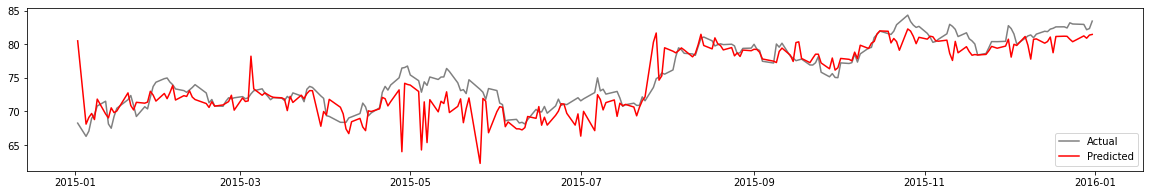

In [168]:
 # create data
x = snp_df[snp_df['Year'].isin([2015])]["Date"]
y1 = snp_df[snp_df['Year'].isin([2015])]['Response']
y2 = grid.predict(snp_df[snp_df['Year'].isin([2015])][["Open", "High", "Low", "Close", "Adj Close", "Volume"]])
  
# plot lines
plt.plot(x, y1, label = "Actual", color='grey')
plt.plot(x, y2, label = "Predicted", color='red')
plt.legend()
plt.show()

# Test Full Results

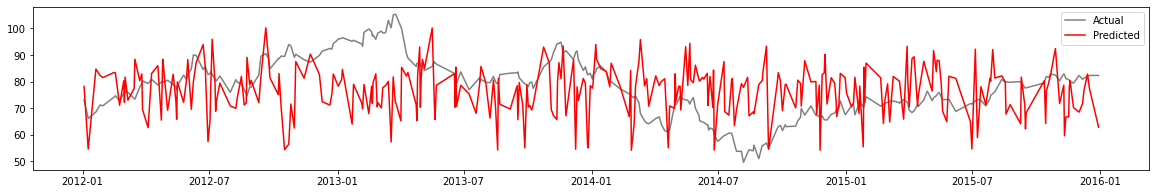

In [170]:
my_list=list(X_test.index)

x = training_period[training_period.index.isin(my_list)]['Date']
y1 = training_period[training_period.index.isin(my_list)]['Response']
y2 = grid.predict(X_test)
  
# plot lines
plt.plot(x, y1, label = "Actual", color='grey')
plt.plot(x, y2, label = "Predicted", color='red')
plt.legend()
plt.show()

In [171]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, grid.predict(X_test))

3.8856180030179313

# Out of Sample Test

In [172]:
out_of_sample = snp_df[snp_df['Year']==2017][["Open", "High", "Low", "Close", "Adj Close", "Volume"]]

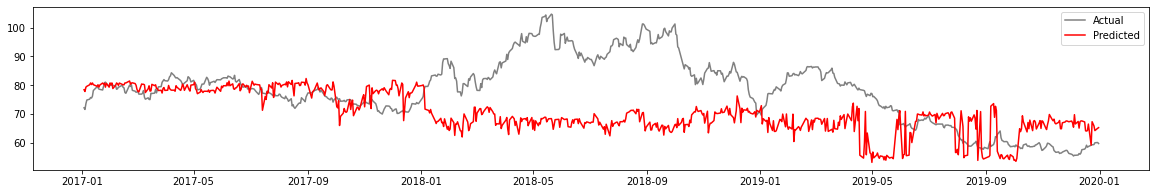

In [173]:
x = snp_df[snp_df['Year'].isin([2017,2018,2019])]["Date"]
y1 = snp_df[snp_df['Year'].isin([2017,2018,2019])]['Open']
y2 = grid.predict(snp_df[snp_df['Year'].isin([2016,2017,2018])][["Open", "High", "Low", "Close", "Adj Close", "Volume"]])
  
# plot lines
plt.plot(x, y1, label = "Actual", color='grey')
plt.plot(x, y2, label = "Predicted", color='red')
plt.legend()
plt.show()